In [306]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_columns', 500)

In [307]:
import os
os.listdir('../../data')

['categories.csv',
 'products.csv',
 'orders.csv',
 'customer.csv',
 'department.csv',
 'order_items.csv']

In [308]:
Categories = pd.read_csv('../../data/categories.csv', delimiter=',')
Products = pd.read_csv('../../data/products.csv', delimiter=';')
Orders = pd.read_csv('../../data/orders.csv', delimiter=';')
Customer = pd.read_csv('../../data/customer.csv', delimiter=';')
Department = pd.read_csv('../../data/department.csv', delimiter=';')
Order_Items = pd.read_csv('../../data/order_items.csv', delimiter=';')

In [309]:
del Customer['customer_email']
del Customer['customer_password']
Customer.head(2)

,customer_id,customer_fname,customer_lname,customer_street,customer_city,customer_state,customer_zipcode
0,1,Richard,Hernandez,6303 Heather Plaza,Brownsville,TX,78521
1,2,Mary,Barrett,9526 Noble Embers Ridge,Littleton,CO,80126


In [310]:
Department.columns.values

array(['department_id', 'department_name'], dtype=object)

In [311]:
Order_Items.columns.values

array(['order_item_id', 'order_item_order_id', 'order_item_product_id',
       'order_item_quantity', 'order_item_subtotal',
       'order_item_product_price'], dtype=object)

In [312]:
def f(startsWith = ''):
    def g(val):
        if(val == startsWith + 'id'):
            return val
        return val.replace(startsWith, '')
    return g

FeatureMatrix = pd.DataFrame.from_dict({
    'Categories': np.vectorize(f('category_'))(Categories.columns.values).tolist(),
    'Products': np.vectorize(f('product_'))(Products.columns.values).tolist(),
    'Orders': np.vectorize(f('order_'))(Orders.columns.values).tolist(),
    'Customer': np.vectorize(f('customer_'))(Customer.columns.values).tolist(),
    'Department': np.vectorize(f('department_'))(Department.columns.values).tolist(),
    'Order_Items': np.vectorize(f('order_item_'))(Order_Items.columns.values).tolist()
}, orient='index').fillna(value = '-')
FeatureMatrix.head(10)

,0,1,2,3,4,5,6
Categories,category_id,department_id,name,-,-,-,-
Products,product_id,category_id,name,description,price,image,-
Orders,order_id,date,customer_id,status,-,-,-
Customer,customer_id,fname,lname,street,city,state,zipcode
Department,department_id,name,-,-,-,-,-
Order_Items,order_item_id,order_id,product_id,quantity,subtotal,product_price,-


We would like to pick up those attributes which answers any of the following question:
* Who purchased
* What purchased
* When purchased
* How much purchased

For the above question set we are picking up relevant feature for our feature matrix, this is totally based on business knowledge. Anything doubtful should be considered `in`.
* **Customer Id** - 
* **city** 
* **street** 
* **zipcode**
* **state**
* **ordered_product_name**
* **ordered_product_desciption**
* **ordered_product_price**
* **ordered_product_has_image**   (As of now, all products has image, we are just including this, but won't use this one) - `Products['product_image'].isnull().sum()`
* **order_date**
* **order_status**
* **department_name** - Not sure how helpful this will be, benefit of doubt goes to addition of attribute.
* **quantity**
* **subtotal**
* **product_price**

#### Biz problem
 - CEO wants to initiate an email marketting campain, so in order to get most out of it, he want to use our knowledge.
 
#### Thought process
 As a data analyst, let's try out a conversation between DA and consumer
 - **DA**: I have sent you a mail. Would you like to check it ?
 - User: Why should I?
 - **DA**: It may contains the items you are interested in?
 - User: May or does it ?
 - **DA**: `We need to figure out the list of items user is interested in`
 - *DA: We have some amazing offers for you?
 - User: Okay !!
 - DA: `We need to find out best combination of interested product and offer`[Out of our scope as dataset doesn't have any attribute for offers and how much to offer depends on business.]
 - User: This list seems to be providing good.

Now, we have following task in hand:
  - We need to figure out the list of items user is interested in
    - **Approach#1** - User might be interested in items in which he was interested in recent past.
    - **Approach#2** - User might be interested items which other similar users has bought. Ex - If i bought TV, then what are those items which other people has purchased along with or in near duration of purchasing a TV.
    - **Approach#3** - User might be offer alcholic - Ex Some users ends up buying lot unnecessary stuff during sale.

## Prepare dataset as required

In [313]:
TempDf1 = pd.merge(Orders, Customer, left_on='order_customer_id', right_on='customer_id')
Tempdf2 = pd.merge(TempDf1, Order_Items, left_on='order_id', right_on='order_item_order_id')
Tempdf3 = pd.merge(Tempdf2, Products, left_on='order_item_product_id', right_on='product_id')
Tempdf4 = pd.merge(Tempdf3, Categories, left_on='product_category_id', right_on='category_id')
Tempdf5 = pd.merge(Tempdf4, Department, left_on='category_department_id', right_on='department_id')
dfToProcess = Tempdf5[[  'customer_id', 
                         'customer_city', 
                         'customer_street', 
                         'customer_state',
                         'customer_zipcode',
                         'product_name',
                         'product_description',
                         'product_price',
                         'product_image',
                         'order_id',
                         'order_date',
                         'order_status',
                         'order_item_quantity',
                         'order_item_subtotal',
                         'category_name',
                         'department_name'
                      ]].copy(deep=True)
# We are not considering following attributes as of now. This is because they need some special attention,
# text processing etc.
columns_not_in_consideration = [
    'customer_city',
    'customer_street',
    'customer_state',
    'customer_zipcode',
    'product_name',
    'product_description',
    'product_image',
    'order_id',
]

columns_to_consider = list(set(dfToProcess.columns)- set(columns_not_in_consideration))
dfToProcess = dfToProcess[columns_to_consider]
dfToProcess.head(3)

,customer_id,order_item_quantity,department_name,category_name,product_price,order_date,order_status,order_item_subtotal
0,11599,1,Fan Shop,Camping & Hiking,299.98,2013-07-25 00:00:00,CLOSED,299.98
1,256,1,Fan Shop,Camping & Hiking,299.98,2014-06-23 00:00:00,COMPLETE,299.98
2,12111,1,Fan Shop,Camping & Hiking,299.98,2013-09-19 00:00:00,COMPLETE,299.98


In [314]:
subTotal = dfToProcess['order_item_subtotal']
qty = dfToProcess['order_item_quantity']
item_price = dfToProcess['product_price']
print('Difference is %.19f' % np.sum(subTotal - (qty*item_price)))

Difference is 0.0000000001940634320


Since `order_item_subtotal = order_item_quantity * product_price`, so we can eliminate `order_item_subtotal` as well.

In [315]:
def drop_redundant_columns(df, redundant_cols=[]):
    df.drop(redundant_cols, inplace=True, axis=1)
    return df

dfToProcess = drop_redundant_columns(dfToProcess ,['order_item_subtotal'])

# Pre-processing

In [316]:
dfToProcess = pd.get_dummies(dfToProcess, columns=['department_name', 'category_name', 'order_status'])

In [317]:
def is_Weekend(date):
    '''
    input: datetime object
    output: 1 => Weekend, 0 => Weekday
    '''
    if_is_weekend = 0 if datetime.weekday(date) < 5 else 1;
    return if_is_weekend

def process_order_date(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['weekend'] = df['order_date'].apply(is_Weekend)
    df['year'] = pd.DatetimeIndex(df['order_date']).year
    df['month'] = pd.DatetimeIndex(df['order_date']).month
    df['day'] = pd.DatetimeIndex(df['order_date']).day
    df.drop('order_date', axis=1, inplace=True)
    return df

dfToProcess = process_order_date(dfToProcess)

In [318]:
dfToProcess.set_index('customer_id', inplace=True)

In [324]:
dfToProcess.head(2)

,order_item_quantity,product_price,department_name_Apparel,department_name_Fan Shop,department_name_Fitness,department_name_Footwear,department_name_Golf,department_name_Outdoors,category_name_Accessories,category_name_As Seen on TV!,category_name_Baseball & Softball,category_name_Basketball,category_name_Boxing & MMA,category_name_Camping & Hiking,category_name_Cardio Equipment,category_name_Cleats,category_name_Electronics,category_name_Fishing,category_name_Fitness Accessories,category_name_Girls' Apparel,category_name_Golf Apparel,category_name_Golf Bags & Carts,category_name_Golf Balls,category_name_Golf Gloves,category_name_Golf Shoes,category_name_Hockey,category_name_Hunting & Shooting,category_name_Indoor/Outdoor Games,category_name_Kids' Golf Clubs,category_name_Lacrosse,category_name_Men's Footwear,category_name_Men's Golf Clubs,category_name_Shop By Sport,category_name_Soccer,category_name_Strength Training,category_name_Tennis & Racquet,category_name_Trade-In,category_name_Water Sports,category_name_Women's Apparel,category_name_Women's Golf Clubs,order_status_CANCELED,order_status_CLOSED,order_status_COMPLETE,order_status_ON_HOLD,order_status_PAYMENT_REVIEW,order_status_PENDING,order_status_PENDING_PAYMENT,order_status_PROCESSING,order_status_SUSPECTED_FRAUD,weekend,year,month,day
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11599,1,299.98,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2013,7,25
256,1,299.98,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2014,6,23


In [331]:
from sklearn.cluster import KMeans
errors = []
for i in [3,4,5,6,7, 8,9,10,11]:
    kmeans = KMeans(n_clusters=i, random_state=0).fit(dfToProcess)
    errors.append(kmeans.inertia_)

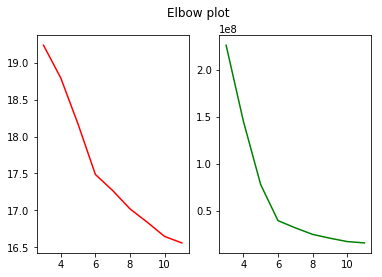

In [370]:
clusters = [3,4,5,6,7, 8,9,10,11];
f, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(clusters, np.log(errors), 'r') # log(error) plot.
ax2.plot(clusters, errors, 'g') # error plot
f.suptitle('Elbow plot')
plt.show()

Given this plot, 6 seems to be r

/Users/ttn/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


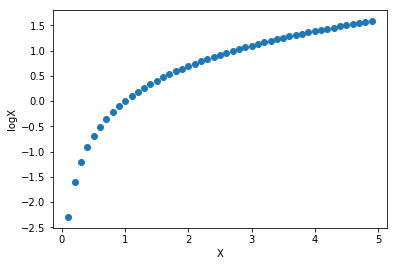

In [359]:
X = np.arange(-5,5,.1)
logX = np.log(X)

plt.scatter(X, logX)  
plt.xlabel('X')
plt.ylabel('logX')
plt.show()